In [1]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob
from rdkit.Chem import inchi
import molvs
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

In [2]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/FDA_approve_sm_molecules
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model


Set the default image size

In [3]:
uru.rd_set_image_size(300,300)

### Reading the data from FDA approved sm molecule drugs

See if they are valid or not

In [4]:
path = '/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/FDA_approve_sm_molecules/drugbank_smdrugs_inchi.txt'
small_molecule_inchi_list = []
with open(path, 'r') as f:
    for line in f:
        small_molecule_inchi_list.append(line.strip())
mol_list = [inchi.MolFromInchi(inchi_str) for inchi_str in small_molecule_inchi_list]


[14:09:01] Cannot assign bond directions!
[14:09:02] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Number; Charge(s): Do not match; Proton balance: Does not match)

[14:09:03] WARNING: not removing hydrogen atom without neighbors
[14:09:03] WARNING: not removing hydrogen atom without neighbors
[14:09:03] WARNING: not removing hydrogen atom without neighbors


Standardize molecules using molvs:

only stereochemistry info is not standardized.

In [5]:
standardizer = molvs.standardize.Standardizer()

def standardize_mol(mol):
    try:
        mol = standardizer.standardize(mol)
        mol = standardizer.fragment_parent(mol, skip_standardize=True)
        mol = standardizer.tautomer_parent(mol, skip_standardize=True)
        mol = standardizer.isotope_parent(mol, skip_standardize=True)
        mol = standardizer.charge_parent(mol, skip_standardize=True)
        return mol
    except:
        return None

In [45]:
### Standardize mol
standardized_mols = []
for mol in tqdm(mol_list, desc="Standardizing molecules", unit="mol"):
    std = standardize_mol(mol)
    standardized_mols.append(std)

### Convert to canonical SMILES
standardized_smiles_list = [Chem.MolToSmiles(mol) for mol in standardized_mols if mol is not None and isinstance(mol, Chem.rdchem.Mol)]
print(len(small_molecule_inchi_list))
len(standardized_smiles_list)

Standardizing molecules:  75%|███████▍  | 2079/2778 [26:57<03:07,  3.72mol/s]  [15:26:57] 

****
Invariant Violation
could not find atom2
Violation occurred on line 228 in file /project/build/temp.linux-x86_64-cpython-311/rdkit/Code/GraphMol/Canon.cpp
Failed Expression: firstFromAtom2
----------
Stacktrace:
----------
****

Standardizing molecules:  94%|█████████▎| 2600/2778 [33:22<00:09, 18.84mol/s][15:33:22] WARNING: not removing hydrogen atom without neighbors
[15:33:22] WARNING: not removing hydrogen atom without neighbors
[15:33:22] WARNING: not removing hydrogen atom without neighbors
Standardizing molecules: 100%|██████████| 2778/2778 [41:53<00:00,  1.11mol/s]


2778


2777

Save the data to a .smi file

In [46]:
with open('drugbank_smdrugs_smiles.txt', 'w') as f:
    for item in standardized_smiles_list:
        f.write("%s\n" % item)

Convert SMILES and name of them to a dataframe

In [47]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

,SMILES
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...
4,N=C(N)NCCC[C@@H](N=C(O)[C@@H]1CCCN1C(=O)[C@@H]...
...,...
2772,CCCCCCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...
2773,CC(C)(C)[Si](F)(c1ccc(C(=O)NC[C@@H](N=C(O)CC[C...
2774,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...
2775,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C


Add an RDKit molecule to the dataframe

In [48]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

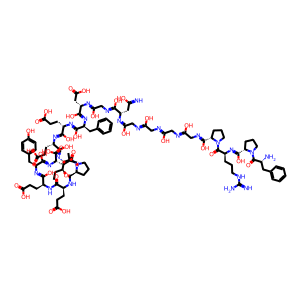

In [49]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [50]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0       [c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...
1       [C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...
2       [c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, O=C1C...
3       [c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...
4       [C1CCNC1, C1=NCC=NCC=NCC=NCC=NCCSSCC1, c1ccccc...
                              ...                        
2772                                                   []
2773                           [c1ccccc1, C1CNCCNCCNCCN1]
2774                        [c1ccsc1, C1=NOCC1, c1ccccc1]
2775                       [O=c1[nH]c(=O)c2[nH]cnc2[nH]1]
2776           [c1c[nH+]n[nH]1, O=C1C[C@@H]2N1CCS2(=O)=O]
Name: ring_sytems, Length: 2777, dtype: object

In [51]:
df.ring_sytems.values

array([list(['c1ccccc1', 'C1CCNC1', 'C1CCNC1', 'c1ccccc1', 'C1CCNC1', 'c1ccccc1']),
       list(['C1CCNC1', 'c1ccccc1', 'c1ccc2[nH]ccc2c1', 'c1c[nH]cn1', 'O=C1CCCN1']),
       list(['c1ccccc1', 'c1ccc2[nH]ccc2c1', 'c1c[nH]cn1', 'O=C1CCCN1', 'C1CCNC1']),
       ..., list(['c1ccsc1', 'C1=NOCC1', 'c1ccccc1']),
       list(['O=c1[nH]c(=O)c2[nH]cnc2[nH]1']),
       list(['c1c[nH+]n[nH]1', 'O=C1C[C@@H]2N1CCS2(=O)=O'])], dtype=object)

In [52]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

,SMILES,Count
0,c1ccccc1,1722
40,C1CCOCC1,189
7,c1ccncc1,135
91,C1CCNCC1,124
43,C1CNCCN1,111
...,...,...
715,N=c1nc2ccccn2[nH]1,1
716,C1CCC2(CCCC2)OC1,1
717,O=c1ccnc2n1CCC2,1
718,c1ccc2c(c1)[nH]c1ccncc12,1


See how many times each ring system occurs

In [53]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

,SMILES,Count
0,c1ccccc1,1722
40,C1CCOCC1,189
7,c1ccncc1,135
91,C1CCNCC1,124
43,C1CNCCN1,111
...,...,...
715,N=c1nc2ccccn2[nH]1,1
716,C1CCC2(CCCC2)OC1,1
717,O=c1ccnc2n1CCC2,1
718,c1ccc2c(c1)[nH]c1ccncc12,1


View the ring system frequencies

In [54]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [55]:
ring_system_lookup = uru.RingSystemLookup()
res = df.mol.apply(ring_system_lookup.process_mol)

In [56]:
res

0       [(c1ccccc1, 2568039), (C1CCNC1, 136431), (C1CC...
1       [(C1CCNC1, 136431), (c1ccccc1, 2568039), (c1cc...
2       [(c1ccccc1, 2568039), (c1ccc2[nH]ccc2c1, 10886...
3       [(c1ccc2[nH]ccc2c1, 108866), (c1ccc2[nH]ccc2c1...
4       [(C1CCNC1, 136431), (C1=NCC=NCC=NCC=NCC=NCCSSC...
                              ...                        
2772                                                   []
2773         [(c1ccccc1, 2568039), (C1CNCCNCCNCCN1, 361)]
2774    [(c1ccsc1, 80452), (C1=NOCC1, 3186), (c1ccccc1...
2775               [(O=c1[nH]c(=O)c2[nH]cnc2[nH]1, 6253)]
2776    [(c1c[nH+]n[nH]1, 214), (O=C1C[C@@H]2N1CCS2(=O...
Name: mol, Length: 2777, dtype: object

In [57]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x70cfa58cc580>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,136431
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e570>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",O=C1CCCN1,18751
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e5e0>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, O=C1C...",O=C1CCCN1,18751
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e650>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,108866
4,N=C(N)NCCC[C@@H](N=C(O)[C@@H]1CCCN1C(=O)[C@@H]...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e6c0>,"[C1CCNC1, C1=NCC=NCC=NCC=NCC=NCCSSCC1, c1ccccc...",C1=NCC=NCC=NCC=NCC=NCCSSCC1,0
...,...,...,...,...,...
2772,CCCCCCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956b90>,[],,-1
2773,CC(C)(C)[Si](F)(c1ccc(C(=O)NC[C@@H](N=C(O)CC[C...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c00>,"[c1ccccc1, C1CNCCNCCNCCN1]",C1CNCCNCCNCCN1,361
2774,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c70>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,3186
2775,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956ce0>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,6253


In [58]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [59]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[15:43:00] WARNING: Omitted undefined stereo

[15:43:00] WARNING: Accepted unusual valence(s): P(6)

[15:43:00] WARNING: Proton(s) added/removed

[15:43:00] WARNING: Omitted undefined stereo

[15:43:00] WARNING: Omitted undefined stereo

[15:43:00] WARNING: Omitted undefined stereo

[15:43:00] WARNING: Omitted undefined stereo

[15:43:00] WARNING: Omitted undefined stereo

[15:43:00] WARNING: Omitted undefined stereo

[15:43:00] WARNING: Accepted unusual valence(s): P(6)

[15:43:00] WARNING: Omitted undefined stereo

[15:43:00] WARNING: Omitted undefined stereo

[15:43:00] WARNING: Omitted undefined stereo

[15:43:00] WARNING: Omitted undefined stereo

[15:43:00] WARNING: Omitted undefined stereo

[15:43:00] WARNING: Omitted undefined stereo

[15:43:00] WARNING: Omitted undefined stereo

[15:43:00] WARNING: Omitted undefined stereo

[15:43:00] WARNING: Omitted undefined stereo

[15:43:00] WARNING: Accepted unusual valence(s): P(6)

[15:43:00] WARNING: Omitted undefined stereo

[15:43:0

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x70cfa58cc580>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,136431,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e570>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",O=C1CCCN1,18751,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e5e0>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, O=C1C...",O=C1CCCN1,18751,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e650>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,108866,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...
4,N=C(N)NCCC[C@@H](N=C(O)[C@@H]1CCCN1C(=O)[C@@H]...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e6c0>,"[C1CCNC1, C1=NCC=NCC=NCC=NCC=NCCSSCC1, c1ccccc...",C1=NCC=NCC=NCC=NCC=NCCSSCC1,0,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...
...,...,...,...,...,...,...
2585,CCCCCCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956b90>,[],,-1,"InChI=1S/C14H17F13/c1-2-3-4-5-6-7-8-9(15,16)10..."
2586,CC(C)(C)[Si](F)(c1ccc(C(=O)NC[C@@H](N=C(O)CC[C...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c00>,"[c1ccccc1, C1CNCCNCCNCCN1]",C1CNCCNCCNCCN1,361,"InChI=1S/C63H99FN12O25Si/c1-62(2,3)102(64,63(4..."
2587,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c70>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,3186,InChI=1S/C20H14Cl3F6N3O3S/c1-8-2-13(36-16(8)17...
2588,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956ce0>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,6253,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...


How many molecules contains ring structure?

In [60]:
df_ring = df[df.min_freq != -1]
df_ring

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x70cfa58cc580>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,136431,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e570>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",O=C1CCCN1,18751,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e5e0>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, O=C1C...",O=C1CCCN1,18751,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e650>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,108866,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...
4,N=C(N)NCCC[C@@H](N=C(O)[C@@H]1CCCN1C(=O)[C@@H]...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e6c0>,"[C1CCNC1, C1=NCC=NCC=NCC=NCC=NCCSSCC1, c1ccccc...",C1=NCC=NCC=NCC=NCC=NCCSSCC1,0,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...
...,...,...,...,...,...,...
2584,COc1ccc(F)cc1C(=O)NCc1ccc(-c2[nH]n([C@@H](C)C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956b20>,"[c1ccccc1, c1ccccc1, N=c1cc[nH][nH]1]",N=c1cc[nH][nH]1,77,"InChI=1S/C22H21F4N5O3/c1-11(22(24,25)26)31-19(..."
2586,CC(C)(C)[Si](F)(c1ccc(C(=O)NC[C@@H](N=C(O)CC[C...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c00>,"[c1ccccc1, C1CNCCNCCNCCN1]",C1CNCCNCCNCCN1,361,"InChI=1S/C63H99FN12O25Si/c1-62(2,3)102(64,63(4..."
2587,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c70>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,3186,InChI=1S/C20H14Cl3F6N3O3S/c1-8-2-13(36-16(8)17...
2588,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956ce0>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,6253,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...


In [61]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x70cfa58cc580>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,136431,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e570>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",O=C1CCCN1,18751,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e5e0>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, O=C1C...",O=C1CCCN1,18751,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e650>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,108866,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...
5,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e730>,"[c1ccc2ccccc2c1, c1ccccc1, c1ccncc1, c1ccccc1,...",c1ccc2ccccc2c1,55872,InChI=1S/C70H92ClN17O14/c1-39(2)31-52(61(94)82...
...,...,...,...,...,...,...
2583,CCCCCCCCCCCCN1CCCCCC1=O,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956a40>,[O=C1CCCCCN1],O=C1CCCCCN1,1828,InChI=1S/C18H35NO/c1-2-3-4-5-6-7-8-9-10-13-16-...
2586,CC(C)(C)[Si](F)(c1ccc(C(=O)NC[C@@H](N=C(O)CC[C...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c00>,"[c1ccccc1, C1CNCCNCCNCCN1]",C1CNCCNCCNCCN1,361,"InChI=1S/C63H99FN12O25Si/c1-62(2,3)102(64,63(4..."
2587,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c70>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,3186,InChI=1S/C20H14Cl3F6N3O3S/c1-8-2-13(36-16(8)17...
2588,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956ce0>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,6253,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...


### How many of them could pass PAINS filter?

Get a list of rules

In [62]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [63]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [64]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [65]:
reos.pandas_mols(df.mol)

  0%|          | 0/2590 [00:00<?, ?it/s]

,rule_set_name,description
0,ok,ok
1,ok,ok
2,ok,ok
3,ok,ok
4,ok,ok
...,...,...
2585,ok,ok
2586,ok,ok
2587,ok,ok
2588,ok,ok


In [66]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/2590 [00:00<?, ?it/s]

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,rule_set_name,description
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x70cfa58cc580>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,136431,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,ok,ok
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e570>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",O=C1CCCN1,18751,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,ok,ok
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e5e0>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, O=C1C...",O=C1CCCN1,18751,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,ok,ok
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e650>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,108866,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...,ok,ok
4,N=C(N)NCCC[C@@H](N=C(O)[C@@H]1CCCN1C(=O)[C@@H]...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e6c0>,"[C1CCNC1, C1=NCC=NCC=NCC=NCC=NCCSSCC1, c1ccccc...",C1=NCC=NCC=NCC=NCC=NCCSSCC1,0,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...,ok,ok
...,...,...,...,...,...,...,...,...
2585,CCCCCCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956b90>,[],,-1,"InChI=1S/C14H17F13/c1-2-3-4-5-6-7-8-9(15,16)10...",ok,ok
2586,CC(C)(C)[Si](F)(c1ccc(C(=O)NC[C@@H](N=C(O)CC[C...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c00>,"[c1ccccc1, C1CNCCNCCNCCN1]",C1CNCCNCCNCCN1,361,"InChI=1S/C63H99FN12O25Si/c1-62(2,3)102(64,63(4...",ok,ok
2587,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c70>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,3186,InChI=1S/C20H14Cl3F6N3O3S/c1-8-2-13(36-16(8)17...,ok,ok
2588,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956ce0>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,6253,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...,ok,ok


test all filters from rd_filter

In [67]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/2590 [00:00<?, ?it/s]

Glaxo 0.8528957528957529 ['Glaxo'] 2209


  0%|          | 0/2590 [00:00<?, ?it/s]

Dundee 0.4833976833976834 ['Dundee'] 1252


  0%|          | 0/2590 [00:00<?, ?it/s]

BMS 0.7640926640926641 ['BMS'] 1979


  0%|          | 0/2590 [00:00<?, ?it/s]

SureChEMBL 0.7162162162162162 ['SureChEMBL'] 1855


  0%|          | 0/2590 [00:00<?, ?it/s]

MLSMR 0.394980694980695 ['MLSMR'] 1023


  0%|          | 0/2590 [00:00<?, ?it/s]

Inpharmatica 0.7200772200772201 ['Inpharmatica'] 1865


  0%|          | 0/2590 [00:00<?, ?it/s]

LINT 0.5891891891891892 ['LINT'] 1526


### How many of them could pass filters suggested by Dr.Reymond?

In [68]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x70cfa58cc580>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,136431,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,True
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e570>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",O=C1CCCN1,18751,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,True
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e5e0>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, O=C1C...",O=C1CCCN1,18751,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,True
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e650>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,108866,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...,True
4,N=C(N)NCCC[C@@H](N=C(O)[C@@H]1CCCN1C(=O)[C@@H]...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e6c0>,"[C1CCNC1, C1=NCC=NCC=NCC=NCC=NCCSSCC1, c1ccccc...",C1=NCC=NCC=NCC=NCC=NCCSSCC1,0,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...,True
...,...,...,...,...,...,...,...
2585,CCCCCCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956b90>,[],,-1,"InChI=1S/C14H17F13/c1-2-3-4-5-6-7-8-9(15,16)10...",True
2586,CC(C)(C)[Si](F)(c1ccc(C(=O)NC[C@@H](N=C(O)CC[C...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c00>,"[c1ccccc1, C1CNCCNCCNCCN1]",C1CNCCNCCNCCN1,361,"InChI=1S/C63H99FN12O25Si/c1-62(2,3)102(64,63(4...",True
2587,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c70>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,3186,InChI=1S/C20H14Cl3F6N3O3S/c1-8-2-13(36-16(8)17...,True
2588,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956ce0>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,6253,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...,True


In [69]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x70cfa58cc580>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,136431,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,True
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e570>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",O=C1CCCN1,18751,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,True
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e5e0>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, O=C1C...",O=C1CCCN1,18751,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,True
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e650>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,108866,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...,True
4,N=C(N)NCCC[C@@H](N=C(O)[C@@H]1CCCN1C(=O)[C@@H]...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e6c0>,"[C1CCNC1, C1=NCC=NCC=NCC=NCC=NCCSSCC1, c1ccccc...",C1=NCC=NCC=NCC=NCC=NCCSSCC1,0,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...,True
...,...,...,...,...,...,...,...
2585,CCCCCCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956b90>,[],,-1,"InChI=1S/C14H17F13/c1-2-3-4-5-6-7-8-9(15,16)10...",True
2586,CC(C)(C)[Si](F)(c1ccc(C(=O)NC[C@@H](N=C(O)CC[C...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c00>,"[c1ccccc1, C1CNCCNCCNCCN1]",C1CNCCNCCNCCN1,361,"InChI=1S/C63H99FN12O25Si/c1-62(2,3)102(64,63(4...",True
2587,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c70>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,3186,InChI=1S/C20H14Cl3F6N3O3S/c1-8-2-13(36-16(8)17...,True
2588,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956ce0>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,6253,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...,True


### How many of them could pass RO5?

In [70]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x70cfa58cc580>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,136431,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,True,False
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e570>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",O=C1CCCN1,18751,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,True,False
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e5e0>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, O=C1C...",O=C1CCCN1,18751,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,True,False
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e650>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,108866,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...,True,False
4,N=C(N)NCCC[C@@H](N=C(O)[C@@H]1CCCN1C(=O)[C@@H]...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e6c0>,"[C1CCNC1, C1=NCC=NCC=NCC=NCC=NCCSSCC1, c1ccccc...",C1=NCC=NCC=NCC=NCC=NCCSSCC1,0,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...,True,False
...,...,...,...,...,...,...,...,...
2585,CCCCCCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956b90>,[],,-1,"InChI=1S/C14H17F13/c1-2-3-4-5-6-7-8-9(15,16)10...",True,False
2586,CC(C)(C)[Si](F)(c1ccc(C(=O)NC[C@@H](N=C(O)CC[C...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c00>,"[c1ccccc1, C1CNCCNCCNCCN1]",C1CNCCNCCNCCN1,361,"InChI=1S/C63H99FN12O25Si/c1-62(2,3)102(64,63(4...",True,False
2587,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c70>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,3186,InChI=1S/C20H14Cl3F6N3O3S/c1-8-2-13(36-16(8)17...,True,False
2588,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956ce0>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,6253,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...,True,True


In [71]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
10,Cc1ncc(CO[PH](=O)(=O)O)c(C=O)c1O,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e960>,[c1ccncc1],c1ccncc1,275595,InChI=1S/C8H9NO6P/c1-5-8(11)7(3-10)6(2-9-5)4-1...,True,True
12,C[S+](CCC(N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(=...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93ea40>,"[C1CCOC1, N=c1[nH]cnc2[nH]cnc12]",N=c1[nH]cnc2[nH]cnc12,30,InChI=1S/C15H22N6O5S/c1-27(3-2-7(16)15(24)25)4...,True,True
13,CC(=O)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93eab0>,[],,-1,"InChI=1S/C3H4O3/c1-2(4)3(5)6/h1H3,(H,5,6)",True,True
14,NC(Cc1ccccc1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93eb20>,[c1ccccc1],c1ccccc1,2568039,InChI=1S/C9H11NO2/c10-8(9(11)12)6-7-4-2-1-3-5-...,True,True
15,O=C(O)CCCC[C@@H]1SC[C@@H]2NC(=O)N[C@@H]21,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93eb90>,[O=C1N[C@H]2CSC[C@H]2N1],O=C1N[C@H]2CSC[C@H]2N1,982,InChI=1S/C10H16N2O3S/c13-8(14)4-2-1-3-7-9-6(5-...,True,True
...,...,...,...,...,...,...,...,...
2579,C[C@H]1CNC(=O)c2cnn3ccc(nc23)N[C@H](C)c2cc(F)c...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956810>,[O=C1NCCOc2ccccc2CNc2ccn3ncc1c3n2],O=C1NCCOc2ccccc2CNc2ccn3ncc1c3n2,6,InChI=1S/C18H18FN5O2/c1-10-8-20-18(25)14-9-21-...,True,True
2580,CCNCc1nc2c(O)c(Cl)cc(Cl)c2c(=O)n1C,<rdkit.Chem.rdchem.Mol object at 0x70cf8f9568f0>,[O=c1[nH]cnc2ccccc12],O=c1[nH]cnc2ccccc12,13851,InChI=1S/C12H13Cl2N3O2/c1-3-15-5-8-16-10-9(12(...,True,True
2584,COc1ccc(F)cc1C(=O)NCc1ccc(-c2[nH]n([C@@H](C)C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956b20>,"[c1ccccc1, c1ccccc1, N=c1cc[nH][nH]1]",N=c1cc[nH][nH]1,77,"InChI=1S/C22H21F4N5O3/c1-11(22(24,25)26)31-19(...",True,True
2588,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956ce0>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,6253,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...,True,True


### Molecules' performance in ring systems from ZINC22 database druglike molecules

In [72]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

0       [(c1ccccc1, 21243538754), (C1CCNC1, 1476304845...
1       [(C1CCNC1, 14763048450), (c1ccccc1, 2124353875...
2       [(c1ccccc1, 21243538754), (c1ccc2[nH]ccc2c1, 6...
3       [(c1ccc2[nH]ccc2c1, 616349280), (c1ccc2[nH]ccc...
4       [(C1CCNC1, 14763048450), (C1=NCC=NCC=NCC=NCC=N...
                              ...                        
2585                                                   []
2586      [(c1ccccc1, 21243538754), (C1CNCCNCCNCCN1, 38)]
2587    [(c1ccsc1, 5148488832), (C1=NOCC1, 571525130),...
2588             [(O=c1[nH]c(=O)c2[nH]cnc2[nH]1, 852928)]
2589    [(c1c[nH+]n[nH]1, 1700), (O=C1C[C@@H]2N1CCS2(=...
Name: mol, Length: 2590, dtype: object

In [73]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x70cfa58cc580>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,14763048450,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,True,False
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e570>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",c1ccc2[nH]ccc2c1,616349280,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,True,False
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e5e0>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, O=C1C...",c1ccc2[nH]ccc2c1,616349280,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,True,False
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e650>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,616349280,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...,True,False
4,N=C(N)NCCC[C@@H](N=C(O)[C@@H]1CCCN1C(=O)[C@@H]...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e6c0>,"[C1CCNC1, C1=NCC=NCC=NCC=NCC=NCCSSCC1, c1ccccc...",C1=NCC=NCC=NCC=NCC=NCCSSCC1,0,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...,True,False
...,...,...,...,...,...,...,...,...
2585,CCCCCCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956b90>,[],,-1,"InChI=1S/C14H17F13/c1-2-3-4-5-6-7-8-9(15,16)10...",True,False
2586,CC(C)(C)[Si](F)(c1ccc(C(=O)NC[C@@H](N=C(O)CC[C...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c00>,"[c1ccccc1, C1CNCCNCCNCCN1]",C1CNCCNCCNCCN1,38,"InChI=1S/C63H99FN12O25Si/c1-62(2,3)102(64,63(4...",True,False
2587,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c70>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,571525130,InChI=1S/C20H14Cl3F6N3O3S/c1-8-2-13(36-16(8)17...,True,False
2588,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956ce0>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,852928,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...,True,True


In [74]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [75]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x70cfa58cc580>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,14763048450,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,True,False
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e570>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",c1ccc2[nH]ccc2c1,616349280,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,True,False
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e5e0>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, O=C1C...",c1ccc2[nH]ccc2c1,616349280,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,True,False
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e650>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,616349280,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...,True,False
5,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e730>,"[c1ccc2ccccc2c1, c1ccccc1, c1ccncc1, c1ccccc1,...",c1ccc2ccccc2c1,152439190,InChI=1S/C70H92ClN17O14/c1-39(2)31-52(61(94)82...,True,False
...,...,...,...,...,...,...,...,...
2583,CCCCCCCCCCCCN1CCCCCC1=O,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956a40>,[O=C1CCCCCN1],O=C1CCCCCN1,95462360,InChI=1S/C18H35NO/c1-2-3-4-5-6-7-8-9-10-13-16-...,True,False
2584,COc1ccc(F)cc1C(=O)NCc1ccc(-c2[nH]n([C@@H](C)C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956b20>,"[c1ccccc1, c1ccccc1, N=c1cc[nH][nH]1]",N=c1cc[nH][nH]1,212718130,"InChI=1S/C22H21F4N5O3/c1-11(22(24,25)26)31-19(...",True,True
2587,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c70>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,571525130,InChI=1S/C20H14Cl3F6N3O3S/c1-8-2-13(36-16(8)17...,True,False
2588,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956ce0>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,852928,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...,True,True


In [76]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x70cfa58cc580>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,14763048450,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,True,False
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e570>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",c1ccc2[nH]ccc2c1,616349280,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,True,False
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e5e0>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, O=C1C...",c1ccc2[nH]ccc2c1,616349280,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,True,False
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e650>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,616349280,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...,True,False
5,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e730>,"[c1ccc2ccccc2c1, c1ccccc1, c1ccncc1, c1ccccc1,...",c1ccc2ccccc2c1,152439190,InChI=1S/C70H92ClN17O14/c1-39(2)31-52(61(94)82...,True,False
...,...,...,...,...,...,...,...,...
2584,COc1ccc(F)cc1C(=O)NCc1ccc(-c2[nH]n([C@@H](C)C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956b20>,"[c1ccccc1, c1ccccc1, N=c1cc[nH][nH]1]",N=c1cc[nH][nH]1,212718130,"InChI=1S/C22H21F4N5O3/c1-11(22(24,25)26)31-19(...",True,True
2586,CC(C)(C)[Si](F)(c1ccc(C(=O)NC[C@@H](N=C(O)CC[C...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c00>,"[c1ccccc1, C1CNCCNCCNCCN1]",C1CNCCNCCNCCN1,38,"InChI=1S/C63H99FN12O25Si/c1-62(2,3)102(64,63(4...",True,False
2587,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c70>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,571525130,InChI=1S/C20H14Cl3F6N3O3S/c1-8-2-13(36-16(8)17...,True,False
2588,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956ce0>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,852928,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...,True,True


In [77]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x70cfa58cc580>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,14763048450,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,True,False
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e570>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",c1ccc2[nH]ccc2c1,616349280,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,True,False
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e5e0>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, O=C1C...",c1ccc2[nH]ccc2c1,616349280,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,True,False
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e650>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,616349280,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...,True,False
5,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e730>,"[c1ccc2ccccc2c1, c1ccccc1, c1ccncc1, c1ccccc1,...",c1ccc2ccccc2c1,152439190,InChI=1S/C70H92ClN17O14/c1-39(2)31-52(61(94)82...,True,False
...,...,...,...,...,...,...,...,...
2584,COc1ccc(F)cc1C(=O)NCc1ccc(-c2[nH]n([C@@H](C)C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956b20>,"[c1ccccc1, c1ccccc1, N=c1cc[nH][nH]1]",N=c1cc[nH][nH]1,212718130,"InChI=1S/C22H21F4N5O3/c1-11(22(24,25)26)31-19(...",True,True
2586,CC(C)(C)[Si](F)(c1ccc(C(=O)NC[C@@H](N=C(O)CC[C...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c00>,"[c1ccccc1, C1CNCCNCCNCCN1]",C1CNCCNCCNCCN1,38,"InChI=1S/C63H99FN12O25Si/c1-62(2,3)102(64,63(4...",True,False
2587,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c70>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,571525130,InChI=1S/C20H14Cl3F6N3O3S/c1-8-2-13(36-16(8)17...,True,False
2588,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956ce0>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,852928,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...,True,True


### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [78]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

0       [(c1ccccc1, 503413992), (C1CCNC1, 136781602), ...
1       [(C1CCNC1, 136781602), (c1ccccc1, 503413992), ...
2       [(c1ccccc1, 503413992), (c1ccc2[nH]ccc2c1, 936...
3       [(c1ccc2[nH]ccc2c1, 9363320), (c1ccc2[nH]ccc2c...
4       [(C1CCNC1, 136781602), (C1=NCC=NCC=NCC=NCC=NCC...
                              ...                        
2585                                                   []
2586        [(c1ccccc1, 503413992), (C1CNCCNCCNCCN1, 56)]
2587    [(c1ccsc1, 33752004), (C1=NOCC1, 1391383), (c1...
2588             [(O=c1[nH]c(=O)c2[nH]cnc2[nH]1, 198315)]
2589    [(c1c[nH+]n[nH]1, 424), (O=C1C[C@@H]2N1CCS2(=O...
Name: mol, Length: 2590, dtype: object

In [79]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x70cfa58cc580>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,136781602,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,True,False
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e570>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",c1ccc2[nH]ccc2c1,9363320,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,True,False
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e5e0>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, O=C1C...",c1ccc2[nH]ccc2c1,9363320,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,True,False
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e650>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,9363320,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...,True,False
4,N=C(N)NCCC[C@@H](N=C(O)[C@@H]1CCCN1C(=O)[C@@H]...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e6c0>,"[C1CCNC1, C1=NCC=NCC=NCC=NCC=NCCSSCC1, c1ccccc...",C1=NCC=NCC=NCC=NCC=NCCSSCC1,0,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...,True,False
...,...,...,...,...,...,...,...,...
2585,CCCCCCCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956b90>,[],,-1,"InChI=1S/C14H17F13/c1-2-3-4-5-6-7-8-9(15,16)10...",True,False
2586,CC(C)(C)[Si](F)(c1ccc(C(=O)NC[C@@H](N=C(O)CC[C...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c00>,"[c1ccccc1, C1CNCCNCCNCCN1]",C1CNCCNCCNCCN1,56,"InChI=1S/C63H99FN12O25Si/c1-62(2,3)102(64,63(4...",True,False
2587,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c70>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,1391383,InChI=1S/C20H14Cl3F6N3O3S/c1-8-2-13(36-16(8)17...,True,False
2588,CC(=O)CCCCn1cnc2c1c(=O)n(C)c(=O)n2C,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956ce0>,[O=c1[nH]c(=O)c2[nH]cnc2[nH]1],O=c1[nH]c(=O)c2[nH]cnc2[nH]1,198315,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-8-14-11...,True,True


In [80]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [81]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CC[C@H](C)[C@H](N=C(O)[C@H](CCC(=O)O)N=C(O)[C@...,<rdkit.Chem.rdchem.Mol object at 0x70cfa58cc580>,"[c1ccccc1, C1CCNC1, C1CCNC1, c1ccccc1, C1CCNC1...",C1CCNC1,136781602,InChI=1S/C98H138N24O33/c1-5-52(4)82(96(153)122...,True,False
1,CCN=C(O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(=N)N)N=C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e570>,"[C1CCNC1, c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]c...",c1ccc2[nH]ccc2c1,9363320,InChI=1S/C59H84N16O12/c1-6-63-57(86)48-14-10-2...,True,False
2,CC(C)C[C@H](N=C(O)[C@@H](COC(C)(C)C)N=C(O)[C@H...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e5e0>,"[c1ccccc1, c1ccc2[nH]ccc2c1, c1c[nH]cn1, O=C1C...",c1ccc2[nH]ccc2c1,9363320,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...,True,False
3,CC(C)C[C@@H](N=C(O)CN=C(O)[C@@H](N=CO)C(C)C)C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e650>,"[c1ccc2[nH]ccc2c1, c1ccc2[nH]ccc2c1, c1ccc2[nH...",c1ccc2[nH]ccc2c1,9363320,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...,True,False
5,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f93e730>,"[c1ccc2ccccc2c1, c1ccccc1, c1ccncc1, c1ccccc1,...",c1ccc2ccccc2c1,4273930,InChI=1S/C70H92ClN17O14/c1-39(2)31-52(61(94)82...,True,False
...,...,...,...,...,...,...,...,...
2580,CCNCc1nc2c(O)c(Cl)cc(Cl)c2c(=O)n1C,<rdkit.Chem.rdchem.Mol object at 0x70cf8f9568f0>,[O=c1[nH]cnc2ccccc12],O=c1[nH]cnc2ccccc12,864191,InChI=1S/C12H13Cl2N3O2/c1-3-15-5-8-16-10-9(12(...,True,True
2583,CCCCCCCCCCCCN1CCCCCC1=O,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956a40>,[O=C1CCCCCN1],O=C1CCCCCN1,1086936,InChI=1S/C18H35NO/c1-2-3-4-5-6-7-8-9-10-13-16-...,True,False
2584,COc1ccc(F)cc1C(=O)NCc1ccc(-c2[nH]n([C@@H](C)C(...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956b20>,"[c1ccccc1, c1ccccc1, N=c1cc[nH][nH]1]",N=c1cc[nH][nH]1,465348,"InChI=1S/C22H21F4N5O3/c1-11(22(24,25)26)31-19(...",True,True
2587,Cc1cc(C2=NO[C@](c3cc(Cl)c(Cl)c(Cl)c3)(C(F)(F)F...,<rdkit.Chem.rdchem.Mol object at 0x70cf8f956c70>,"[c1ccsc1, C1=NOCC1, c1ccccc1]",C1=NOCC1,1391383,InChI=1S/C20H14Cl3F6N3O3S/c1-8-2-13(36-16(8)17...,True,False
